# **GIS × Python Tutorial 7.1 ~ RasterDataことはじめ ~**
---
この記事は「GIS × Python Tutorial」の関連記事です。

<br>


## **はじめに**
---
今回からの Tutorial 7.x では Raster データの扱いについて解説していきます。Tutorial 6.x で Lidar で取得した点群データを扱う際に少し rasterio について触れましたが、7.x ではより詳しく Raster の扱い方を解説していきます。初回の今回は最も基本的な IO 処理に関してです。

<br>


## **Raster データとは**
---
Tutorial 6.x と同じ事を書いているので、前に読んだ方は飛ばしていただいても構いません。

"Raster Data" とは画像と同じように行列に数値が入力されたデータです。PCなどで画像を拡大すると格子状に色が並んでいるのが確認できますが、この時見える一つ一つの四角を 'セル（ピクセル）'と呼びます。

通常のRGB画像は大抵 '8bit' だと思うので、セルの中には**2の8乗で [0～255] の範囲の整数（0 始まりなので）** が入力されています。

画像を扱った事が無い方は、Excel でイメージしてもいいかもしれません。Excel の Sheet を3枚用意し、「Sheet1にはRed」「Sheet2にはGreen」「Sheet3にはBlue」という名前を付けます。方眼紙の様にセルの形を整え（例: 150px × 100px  行×列）、そのセルに格子線を引きます。その全てのセルには [0～255] の整数が入力されています。

この数値は色の強さを表すもので、セルA1（座標: 0, 0）が「Sheet Red: 255, Sheet Green: 0, Sheet Blue: 0」ならばそのセルは赤く表示されます。セルA2（座標: 1, 0）が「Sheet Red: 0, Sheet Green: 255, Sheet Blue: 0」ならばそのセルは
濃い緑色に表示されます。ちなみに全てが255ならば白になり、全てが0ならば黒になります。

これはRGB画像の場合ですが、"Raster Data" で表現するものによっては、上で示した3次元のデータではなく、2次元の行列にFloat型の数値が入力されていたりします。

座標の情報と形を保有している "Vector Data" とは違い、"Raster Data" のセルの大きさは決まっていますので、セルの大きさ（例えば 10m×10m）よりも小さな情報を表現する事は出来ませんので、拡大しすぎると劣化してしまいますが、計算が単純なので非常に扱いやすいデータです。

<br>


## **GDALとrasterio**
---
python で Raster データを扱おうとして調べるとおそらくこの 2つがまず目に入ると思います。数年前の話で記憶も確かではありませんが、私が python で GIS を扱い始めた当時は GDAL のドキュメントが非常に読みづらかった記憶があり、私は rasterio をメインに使い始めました。しかし、最近 QGIS の Plugin を作る勉強を始めて、QGIS 環境には rasterio が Install されていないので、仕方がなく GDAL のドキュメントを読みに行きましたが、大分読みやすくなっていて驚いたのが最近の出来事です。

GDAL も rasterio と比べると python で扱うならば rasterio の方がコードの行数も少なく済み、扱いやすいとは思いますが今回はその比較もかねて両方のコードを書いていきたいと思います。

In [112]:
from rasterio import Affine

from IPython.display import Image
import japanize_matplotlib
import numpy as np
from matplotlib import pyplot as plt
from osgeo import gdal
import pyproj
import rasterio
import rasterio.plot
japanize_matplotlib.japanize()


IN_EPSG = 'EPSG:6678'
proj_crs = pyproj.CRS(IN_EPSG)
IN_SRS = proj_crs.to_wkt(pretty=True)

<br>

## **Rasterデータの作成**
---
まずは Raster データを作成してみましょう。今回は [0~255] までの値を使用した 3枚の rows:15, cols:20 の配列を作成します。

In [7]:
cols = 20
rows = 15
image = []
for _ in range(3):
    img = np.array([np.random.randint(0, 256, cols) for i in range(rows)])
    image.append(img)

image = np.array(image)
print(f"shape: {image.shape}")

shape: (3, 15, 20)


画像を扱う方は気づいたかもしれませんが、Raster の配列は(次元数, 行数, 列数)です。`matplotlib.pyplot.imread`などで画像を読み込む時は（行数, 列数, 次元数）となっているのでスライスの仕方が変わってきます。また 'matplotlib.pyplot.imshow' で可視化するならば配列の奥行を変更する必要があります。ちょっと試してみましょう。

In [10]:
image_ = np.dstack(image)
print(f"shape: {image_.shape}")

shape: (15, 20, 3)


配列の奥行が変わったのが確認出来ましたので可視化してみましょう。

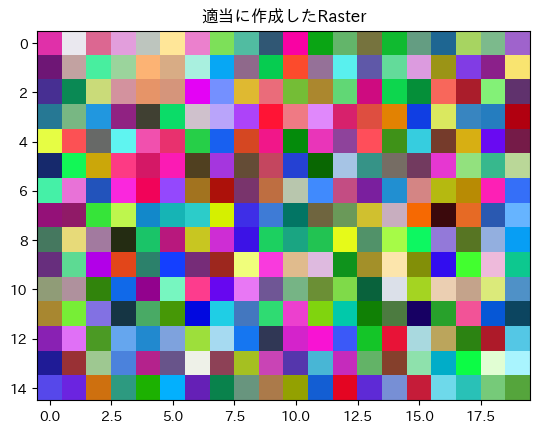

In [86]:
fig, ax = plt.subplots()
ax.set_title('適当に作成したRaster')
ax.imshow(image_, cmap='terrain');

<br>

## **GDALを使用したRasterの書き込み**
---
GDAL での書き込みワークフローは以下の通りです。

 1. メタデータの設定
    - X方向セル数
    - Y方向セル数
    - バンド数
    - データ型

 2. gdal.Dataset の作成
    - メタデータを設定

 3. 空間参照系の設定

 4. 座標やセルサイズの設定

 5. Rasterの書き込み
    - 指定のバンドに指定の配列を書き込む
    - Nodataの設定

 6. データセットを閉じてリソースを開放する

In [129]:
# ファイルパス
RASTER_FILE_GDAL = r'..\images\session7\RASTER_GDAL.tif'

# メタデータの準備
meta_data = dict(
    utf8_path=RASTER_FILE_GDAL,
    xsize=cols,
    ysize=rows,
    bands=3,
    eType=gdal.GDT_Byte
)


# gdal.Datasetの作成
gdal_dst = (
    gdal
    .GetDriverByName('GTiff')
    .Create(**meta_data)
)


# 空間参照系の定義
gdal_dst.SetProjection(IN_SRS)

# 今回は適当に弘前城の近くに投影します
# 座標やセルサイズの定義
# [X_Min, セルの幅, 行回転, Y_Max, 列回転, セルの高さ]
transform = [-31270, 1, 0, 67573, 0, -1]
gdal_dst.SetGeoTransform(transform)


# Rasterの書き込み
for band, ary in enumerate(image):
    band += 1
    gdal_dst.GetRasterBand(band).WriteArray(ary)
    gdal_dst.GetRasterBand(band).SetNoDataValue(-999)
gdal_dst.FlushCache()
gdal_dst.Close()

0

QGISで確認してみると設定した通りに投影されているのが確認できます。

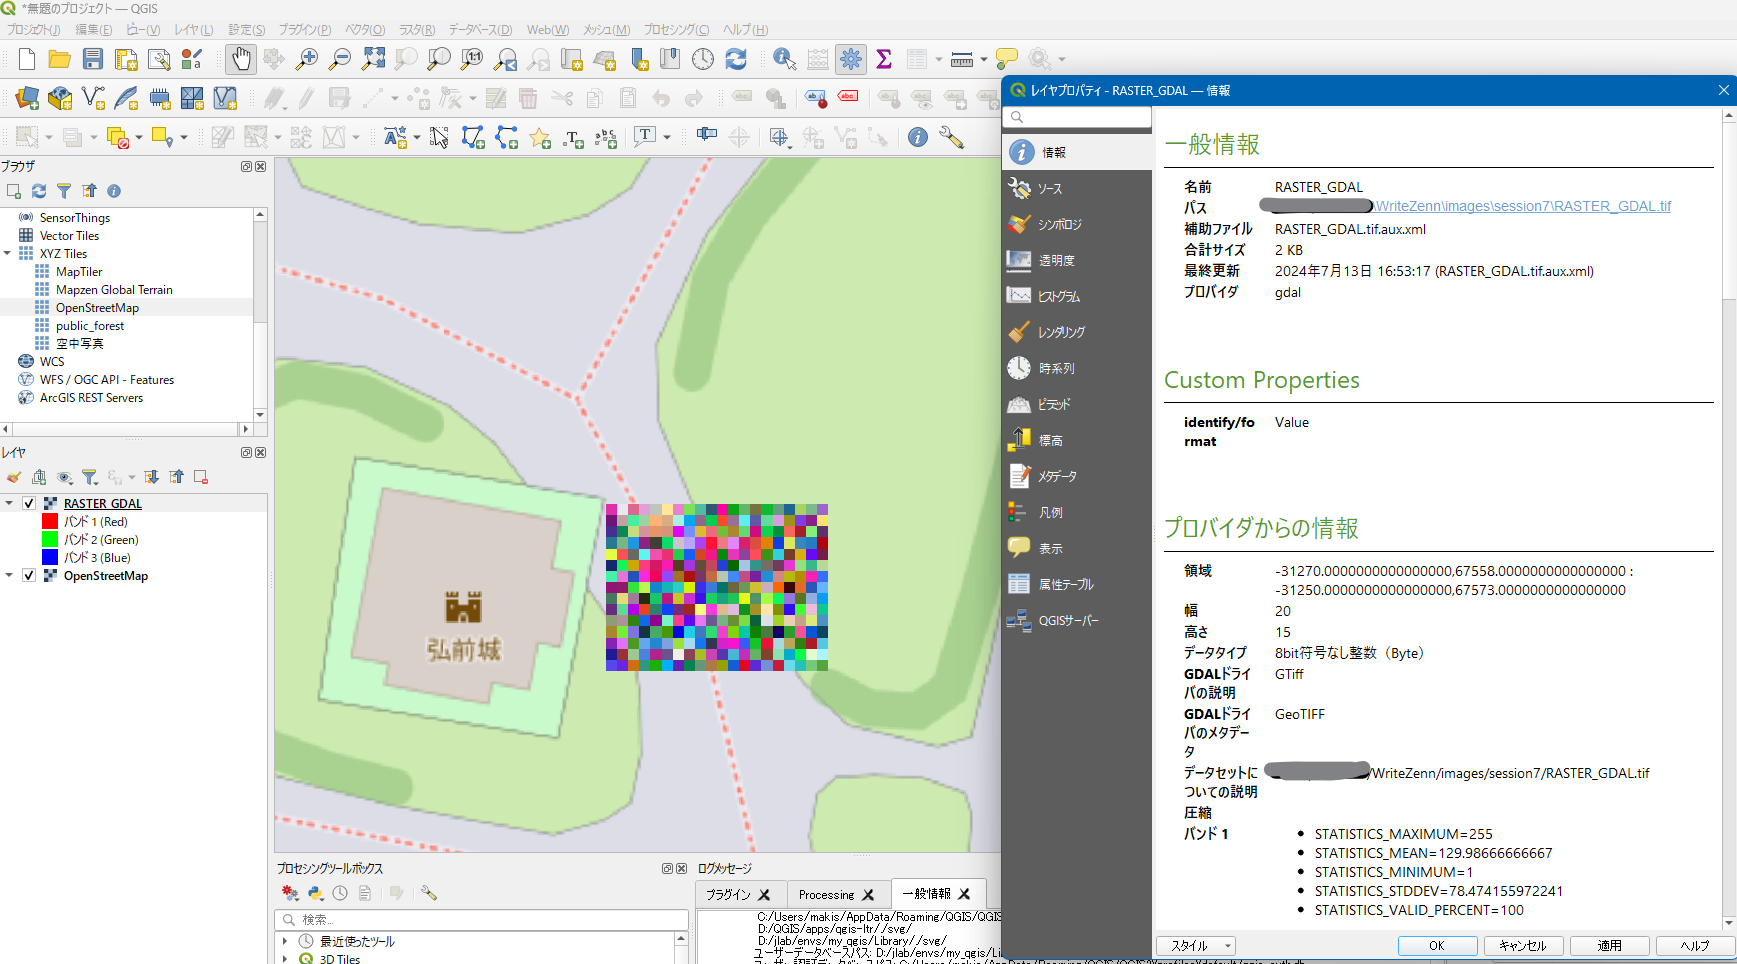

In [116]:

display_width = 1000

Image(r'../images/session7/drop_qgis.png', width=display_width)

<br>

## **GDALを使用したRasterの読み込み**
---
Rasterデータを読み込む場合は書き込みと比べて行数が少なく済みます。

< GDAL >
Projection: PROJCS["JGD2011 / Japan Plane Rectangular CS X",GEOGCS["JGD2011",DATUM["Japanese_Geodetic_Datum_2011",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","1128"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","6668"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",40],PARAMETER["central_meridian",140.833333333333],PARAMETER["scale_factor",0.9999],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Northing",NORTH],AXIS["Easting",EAST],AUTHORITY["EPSG","6678"]]
Transform: (-31270.0, 1.0, 0.0, 67573.0, 0.0, -1.0)
Bands: 3
Array shape: (3, 15, 20)



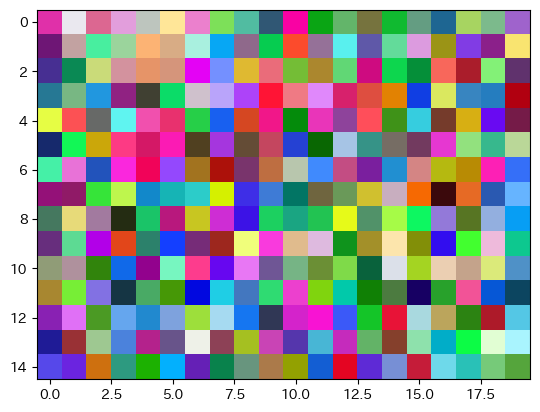

In [117]:
gdal_dst = gdal.Open(RASTER_FILE_GDAL)
gdal_ary = gdal_dst.ReadAsArray(0)


print(f"""< GDAL >
Projection: {gdal_dst.GetProjection()}
Transform: {gdal_dst.GetGeoTransform()}
Bands: {gdal_dst.RasterCount}
Array shape: {gdal_ary.shape}
""")
plt.imshow(np.dstack(gdal_ary));

<br>

## **rasterioを使用したRasterの書き込み**
---
次は rasterio での書き込みワークフローを見てみましょう。rasterio では GDAL とは違いバンド数やセル数のほかに空間参照系なども全てデータセットを開く際に指定します。

 1. メタデータの準備
    - 画像フォーマット
    - データ型
    - バンド数
    - X方向セル数
    - Y方向セル数
    - 空間参照系
    - 座標やセルサイズ

 2. Rasterの書き込み


ここで注意が必要な事は GDAL と rasterio の transform に渡す値の順番が違う事です。

In [126]:
import pandas as pd
print(pd.DataFrame({
'GDAL': ['X座標の最大値', 'セル幅', 'X回転', 'Y座標の最大値', 'Y回転', 'セルの高さ'],
'rasterio': ['セル幅', 'X回転', 'X座標の最大値', 'Y回転', 'セルの高さ', 'Y座標の最大値']
}
).T.to_markdown())

|          | 0             | 1      | 2             | 3             | 4          | 5             |
|:---------|:--------------|:-------|:--------------|:--------------|:-----------|:--------------|
| GDAL     | X座標の最大値 | セル幅 | X回転         | Y座標の最大値 | Y回転      | セルの高さ    |
| rasterio | セル幅        | X回転  | X座標の最大値 | Y回転         | セルの高さ | Y座標の最大値 |


In [132]:
# ファイルパス
RASTER_FILE_RIO = r'../images/session7/RASTER_RIO.tif'


# メタデータの準備
meta_data = dict(
    driver='GTiff',
    dtype=rasterio.dtypes.uint8,
    count=3,
    width=cols,
    height=rows,
    crs=IN_SRS,
    transform=Affine(1, 0, -31270, 0, -1, 67573)
)


# Rasterの書き込み
with rasterio.open(RASTER_FILE_RIO, mode='w', **meta_data) as rio_dst:
    for band, ary in enumerate(image):
        rio_dst.write(ary, band + 1)

QGISで確認してみると設定した通りに投影されているのが確認できます。

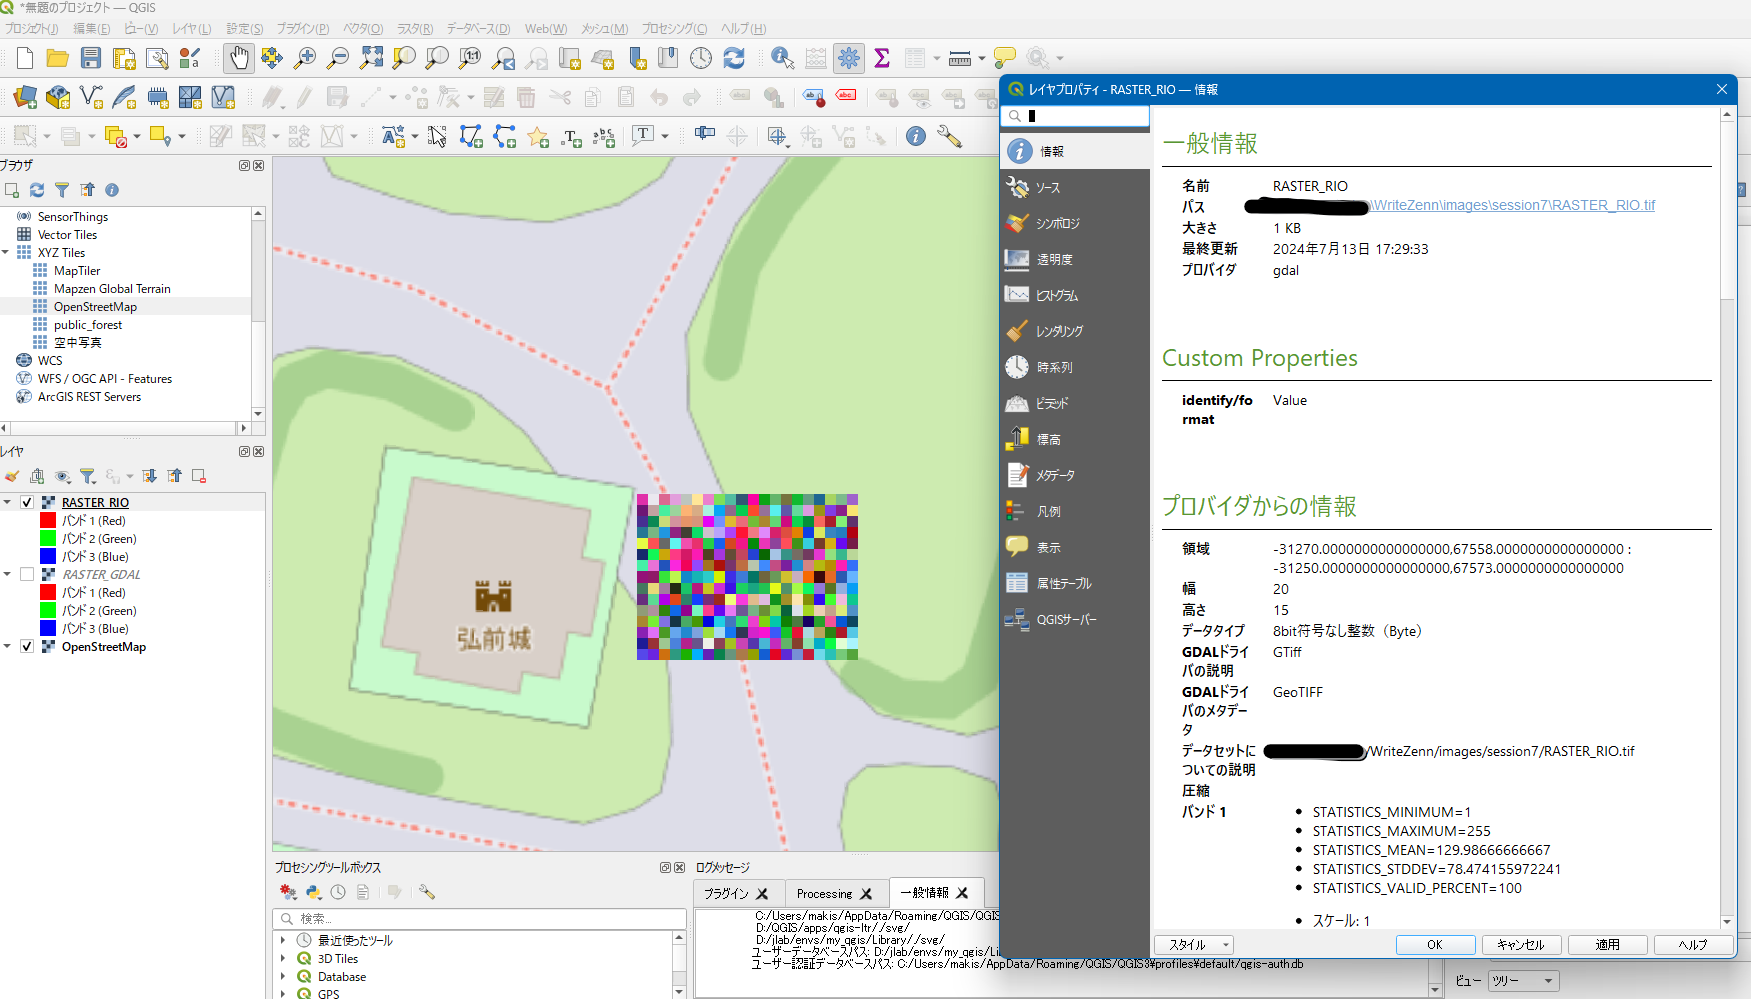

In [133]:

display_width = 1000

Image(r'../images/session7/drop_qgis_rio.png', width=display_width)

<br>

## **rasterioを使用したRasterの読み込み**
---
読み込みに関しては GDAL も rasterio も変わりません。

< rasterio >
Projection: PROJCS["JGD2011 / Japan Plane Rectangular CS X",GEOGCS["JGD2011",DATUM["Japanese_Geodetic_Datum_2011",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","1128"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","6668"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",40],PARAMETER["central_meridian",140.833333333333],PARAMETER["scale_factor",0.9999],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Northing",NORTH],AXIS["Easting",EAST],AUTHORITY["EPSG","6678"]]
Transform: 
| 1.00, 0.00,-31270.00|
| 0.00,-1.00, 67573.00|
| 0.00, 0.00, 1.00|
Bands: (1, 2, 3)
Array shape: (3, 15, 20)



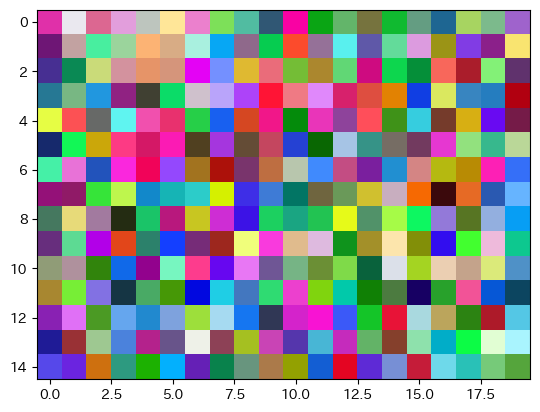

In [138]:
rio_dst = rasterio.open(RASTER_FILE_RIO)
rio_ary = rio_dst.read()

print(f"""< rasterio >
Projection: {rio_dst.read_crs().to_wkt()}
Transform: 
{rio_dst.transform}
Bands: {rio_dst.indexes}
Array shape: {rio_ary.shape}
""")
plt.imshow(np.dstack(rio_ary));